<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/BP_2004_GPU_T4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 15.8 MB/s eta 0:00:00


Using device: cuda
Grid: 1799x637 | dx=37.5m | Target: 7.0Hz

--- STAGE 1: 3.0 Hz ---
Epoch 5/50 | Scaled Loss: 0.133028
Epoch 10/50 | Scaled Loss: 0.102617
Epoch 15/50 | Scaled Loss: 0.085668
Epoch 20/50 | Scaled Loss: 0.075131
Epoch 25/50 | Scaled Loss: 0.068981
Epoch 30/50 | Scaled Loss: 0.060374
Epoch 35/50 | Scaled Loss: 0.057806
Epoch 40/50 | Scaled Loss: 0.054639
Epoch 45/50 | Scaled Loss: 0.050181
Epoch 50/50 | Scaled Loss: 0.050401

--- STAGE 2: 5.0 Hz ---
Epoch 5/50 | Scaled Loss: 0.131743
Epoch 10/50 | Scaled Loss: 0.109975
Epoch 15/50 | Scaled Loss: 0.113235
Epoch 20/50 | Scaled Loss: 0.097356
Epoch 25/50 | Scaled Loss: 0.097982
Epoch 30/50 | Scaled Loss: 0.090410
Epoch 35/50 | Scaled Loss: 0.089451
Epoch 40/50 | Scaled Loss: 0.088255
Epoch 45/50 | Scaled Loss: 0.092076
Epoch 50/50 | Scaled Loss: 0.095824

--- STAGE 3: 7.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 37.5, there are only 5.44.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1449.999755859375, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(


Epoch 5/50 | Scaled Loss: 0.152799
Epoch 10/50 | Scaled Loss: 0.151150
Epoch 15/50 | Scaled Loss: 0.146509
Epoch 20/50 | Scaled Loss: 0.148605
Epoch 25/50 | Scaled Loss: 0.140622
Epoch 30/50 | Scaled Loss: 0.131128
Epoch 35/50 | Scaled Loss: 0.136416
Epoch 40/50 | Scaled Loss: 0.131069
Epoch 45/50 | Scaled Loss: 0.141437
Epoch 50/50 | Scaled Loss: 0.136192


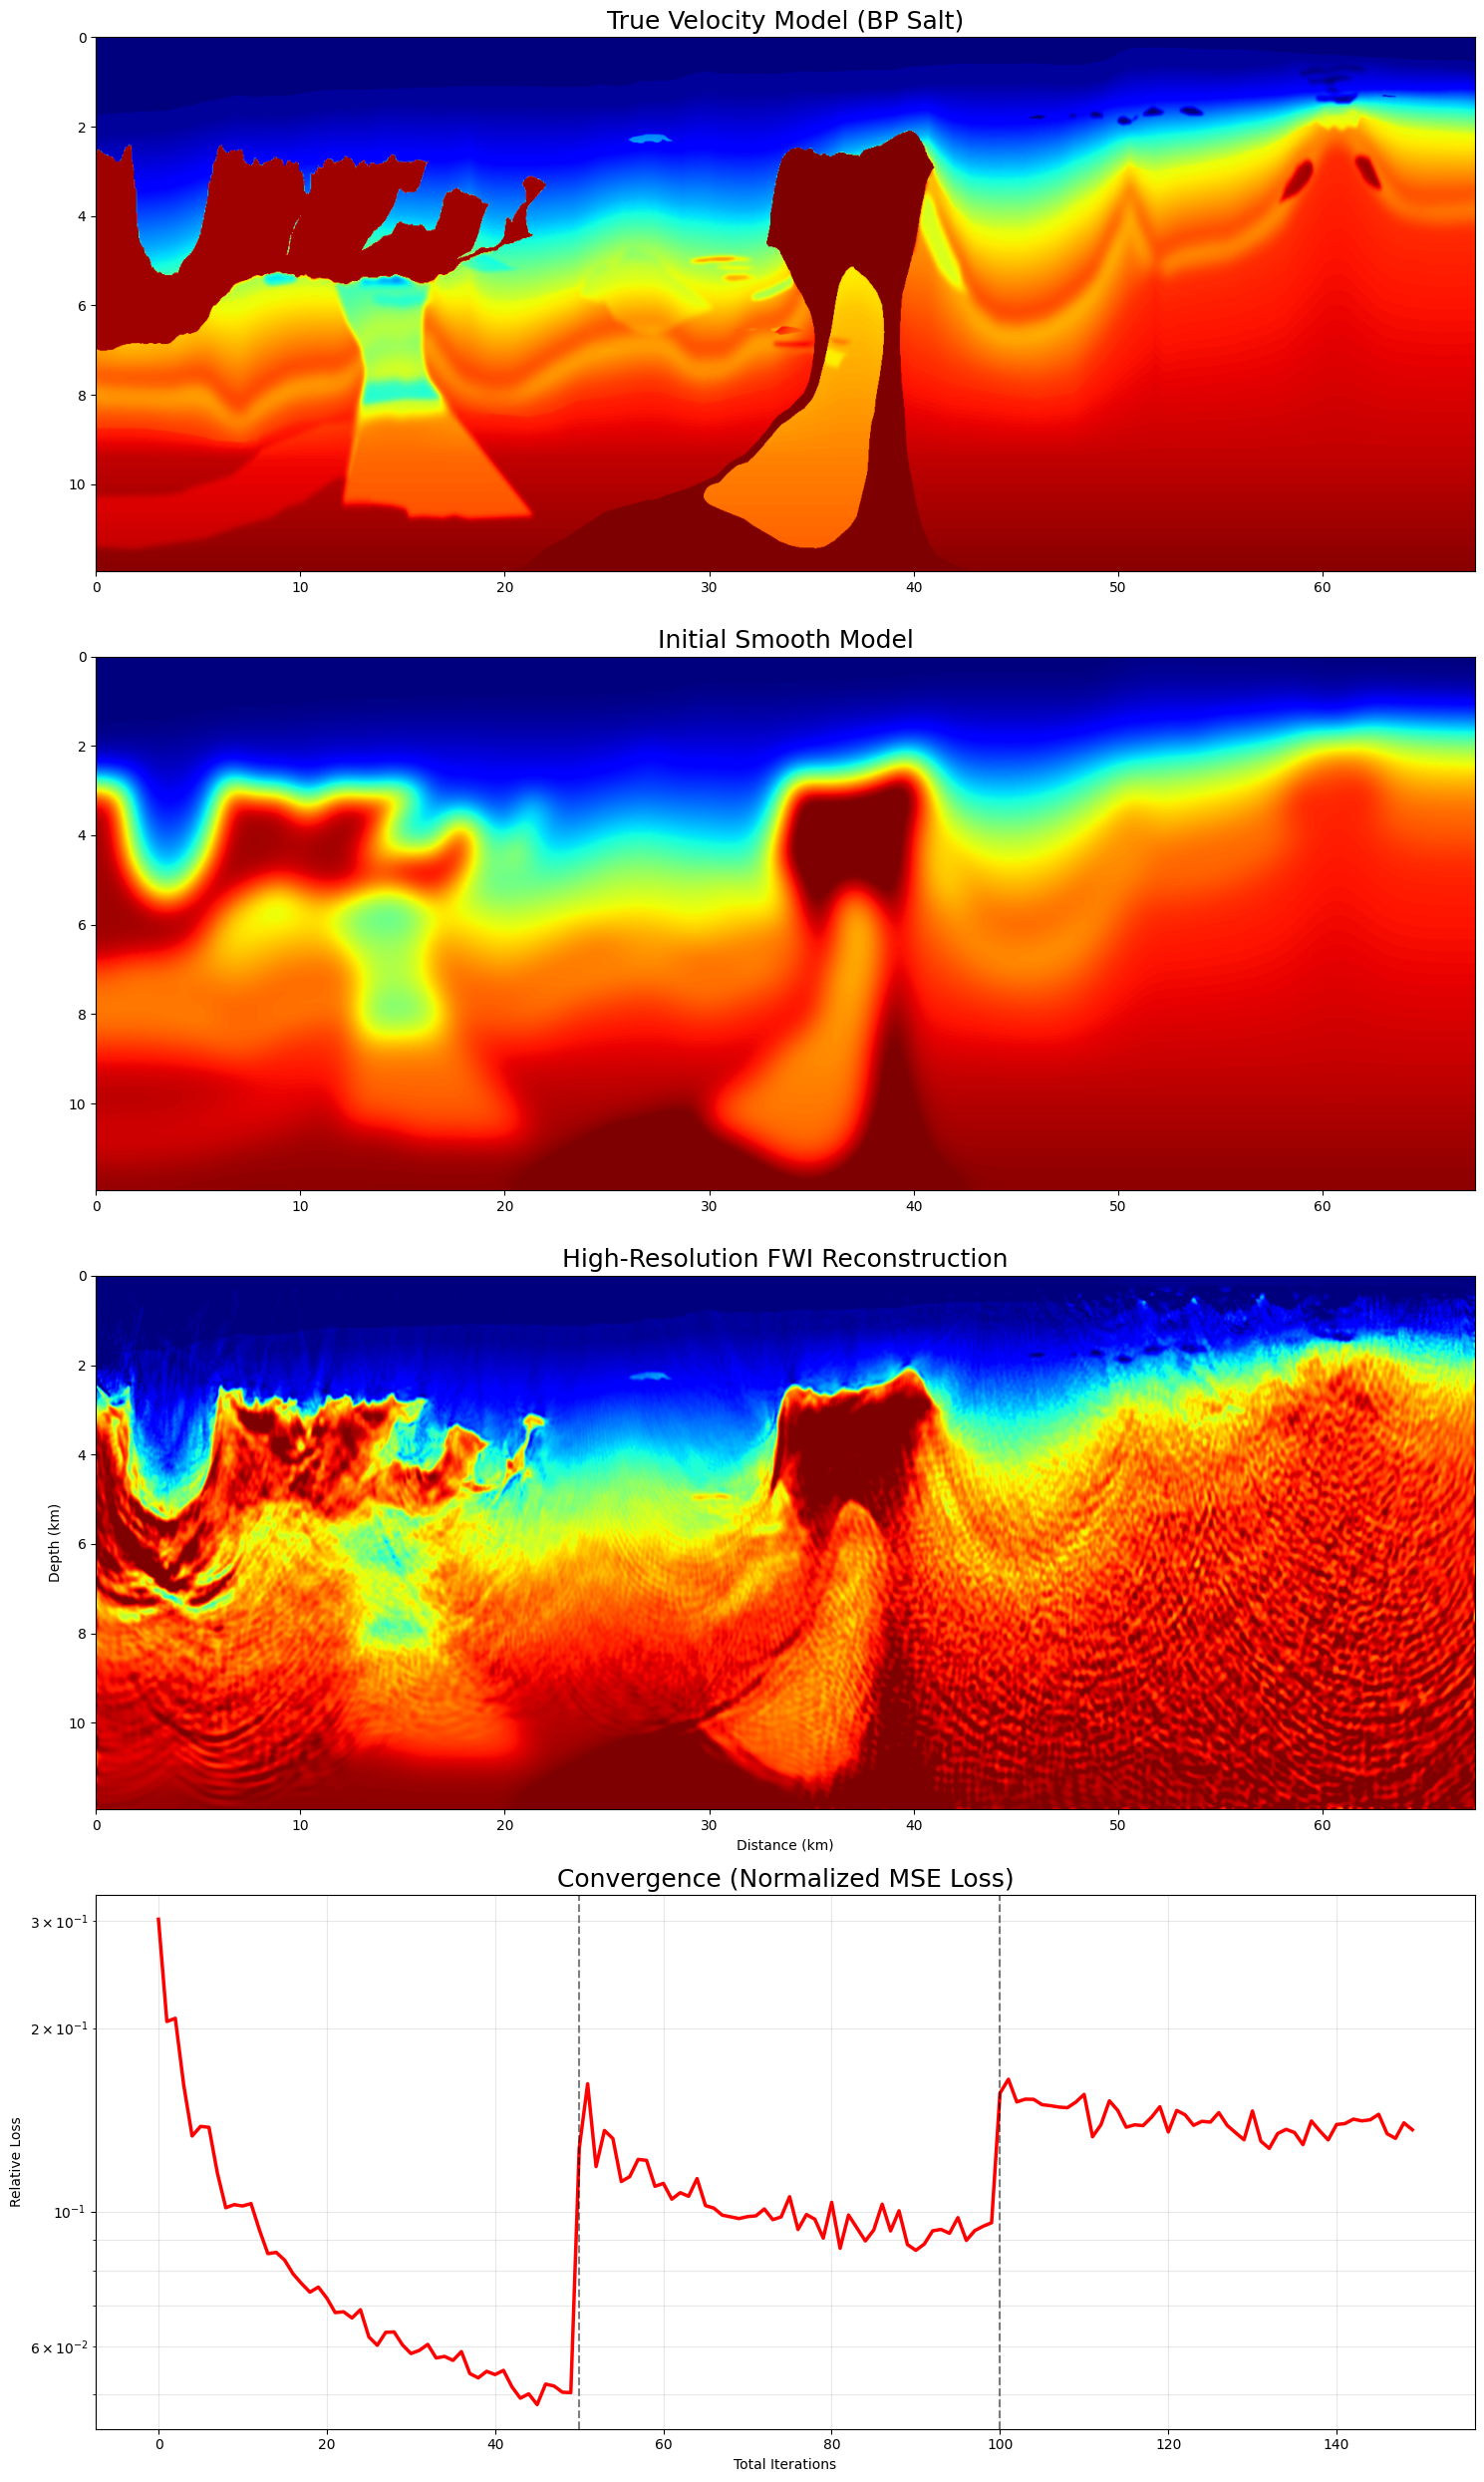

In [ ]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION & MEMORY ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- ADVANCED GPU SMOOTHING (Edge Preserving) ---
def gpu_smooth(img, sigma):
    if sigma <= 0.1: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL LOADING ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Warning: BP_salt.bin not found. Using dummy for script verification.")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 3.0 (dx=37.5m) - This eliminates the 6Hz dispersion warning
factor = 3.0
vp_reduced = gaussian_filter(vp_cpu.numpy(), sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=20)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION ---
n_shots = 24
batch_size = 3 # Adjusted for 15GB VRAM at dx=37.5
n_receivers_per_shot = 400
nt = 2000
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(20, nx - 21, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 45.0 * z_grad**2.5).repeat(nx, 1) # Stronger weight for salt base

# --- MULTI-SCALE INVERSION ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = 50
# Gradual learning rate reduction
lrs = [25.0, 15.0, 8.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx:.1f}m | Target: {freqs[-1]}Hz")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Observe data with wider PML to avoid boundary reflections (ripples)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:min(i+batch_size, n_shots)],
                         source_locations=source_loc[i:min(i+batch_size, n_shots)],
                         receiver_locations=receiver_loc[i:min(i+batch_size, n_shots)],
                         pml_freq=freq, pml_width=[40, 40, 40, 40])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        # Randomize shots to help skip local minima
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:min(i+batch_size, n_shots)]

            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10) # VRAM Save

            # Normalizing loss by the scale of the observed data to prevent "jumps"
            loss = F.mse_loss(out_pred[-1], obs_data[indices]) / F.mse_loss(obs_data[indices], torch.zeros_like(obs_data[indices]))
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            # Apply Mask and Depth Gain
            v1.grad *= (mask * depth_weight)

            # Multi-scale smoothing: Sigma decreases as frequency increases
            # This allows the model to capture details while keeping salt solid
            sigma_val = 3.5 / (f_idx + 1)
            v1.grad.copy_(gpu_smooth(v1.grad, sigma=sigma_val))

        optimizer.step()

        # Hard constraints for BP model stability
        v1.data.clamp_(min=1450.0, max=4850.0)

        # Smooth the model itself slightly every epoch to prevent "checkerboard" artifacts
        if epoch % 2 == 0:
            v1.data.copy_(gpu_smooth(v1.data, sigma=0.2))

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage} | Scaled Loss: {avg_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4600}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=18)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial Smooth Model", fontsize=18)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("High-Resolution FWI Reconstruction", fontsize=18)
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Depth (km)")

# Improved Loss Plot
ax[3].plot(history, color='red', lw=2.5)
ax[3].set_title("Convergence (Normalized MSE Loss)", fontsize=18)
ax[3].set_xlabel("Total Iterations")
ax[3].set_ylabel("Relative Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.3)
# Mark stage transitions
for i in range(1, len(freqs)):
    ax[3].axvline(x=i*epochs_per_stage, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Using device: cuda
Grid: 1799x637 | dx=37.5m | Target: 7.0Hz

--- STAGE 1: 3.0 Hz ---
Epoch 5/100 | Scaled Loss: 0.140829
Epoch 10/100 | Scaled Loss: 0.103997
Epoch 15/100 | Scaled Loss: 0.086968
Epoch 20/100 | Scaled Loss: 0.074958
Epoch 25/100 | Scaled Loss: 0.065922
Epoch 30/100 | Scaled Loss: 0.059962
Epoch 35/100 | Scaled Loss: 0.053996
Epoch 40/100 | Scaled Loss: 0.051108
Epoch 45/100 | Scaled Loss: 0.048577
Epoch 50/100 | Scaled Loss: 0.050558
Epoch 55/100 | Scaled Loss: 0.048273
Epoch 60/100 | Scaled Loss: 0.046149
Epoch 65/100 | Scaled Loss: 0.044204
Epoch 70/100 | Scaled Loss: 0.045145
Epoch 75/100 | Scaled Loss: 0.039418
Epoch 80/100 | Scaled Loss: 0.041532
Epoch 85/100 | Scaled Loss: 0.041045
Epoch 90/100 | Scaled Loss: 0.041026
Epoch 95/100 | Scaled Loss: 0.038598
Epoch 100/100 | Scaled Loss: 0.041141

--- STAGE 2: 5.0 Hz ---
Epoch 5/60 | Scaled Loss: 0.114164
Epoch 10/60 | Scaled Loss: 0.100703
Epoch 15/60 | Scaled Loss: 0.087721
Epoch 20/60 | Scaled Loss: 0.088548
Epoch 

/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 37.5, there are only 5.44.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1449.999755859375, and a grid cell spacing of 37.5, there are only 5.52.
  warnings.warn(


Epoch 5/20 | Scaled Loss: 0.134759
Epoch 10/20 | Scaled Loss: 0.137291
Epoch 15/20 | Scaled Loss: 0.133997
Epoch 20/20 | Scaled Loss: 0.139264


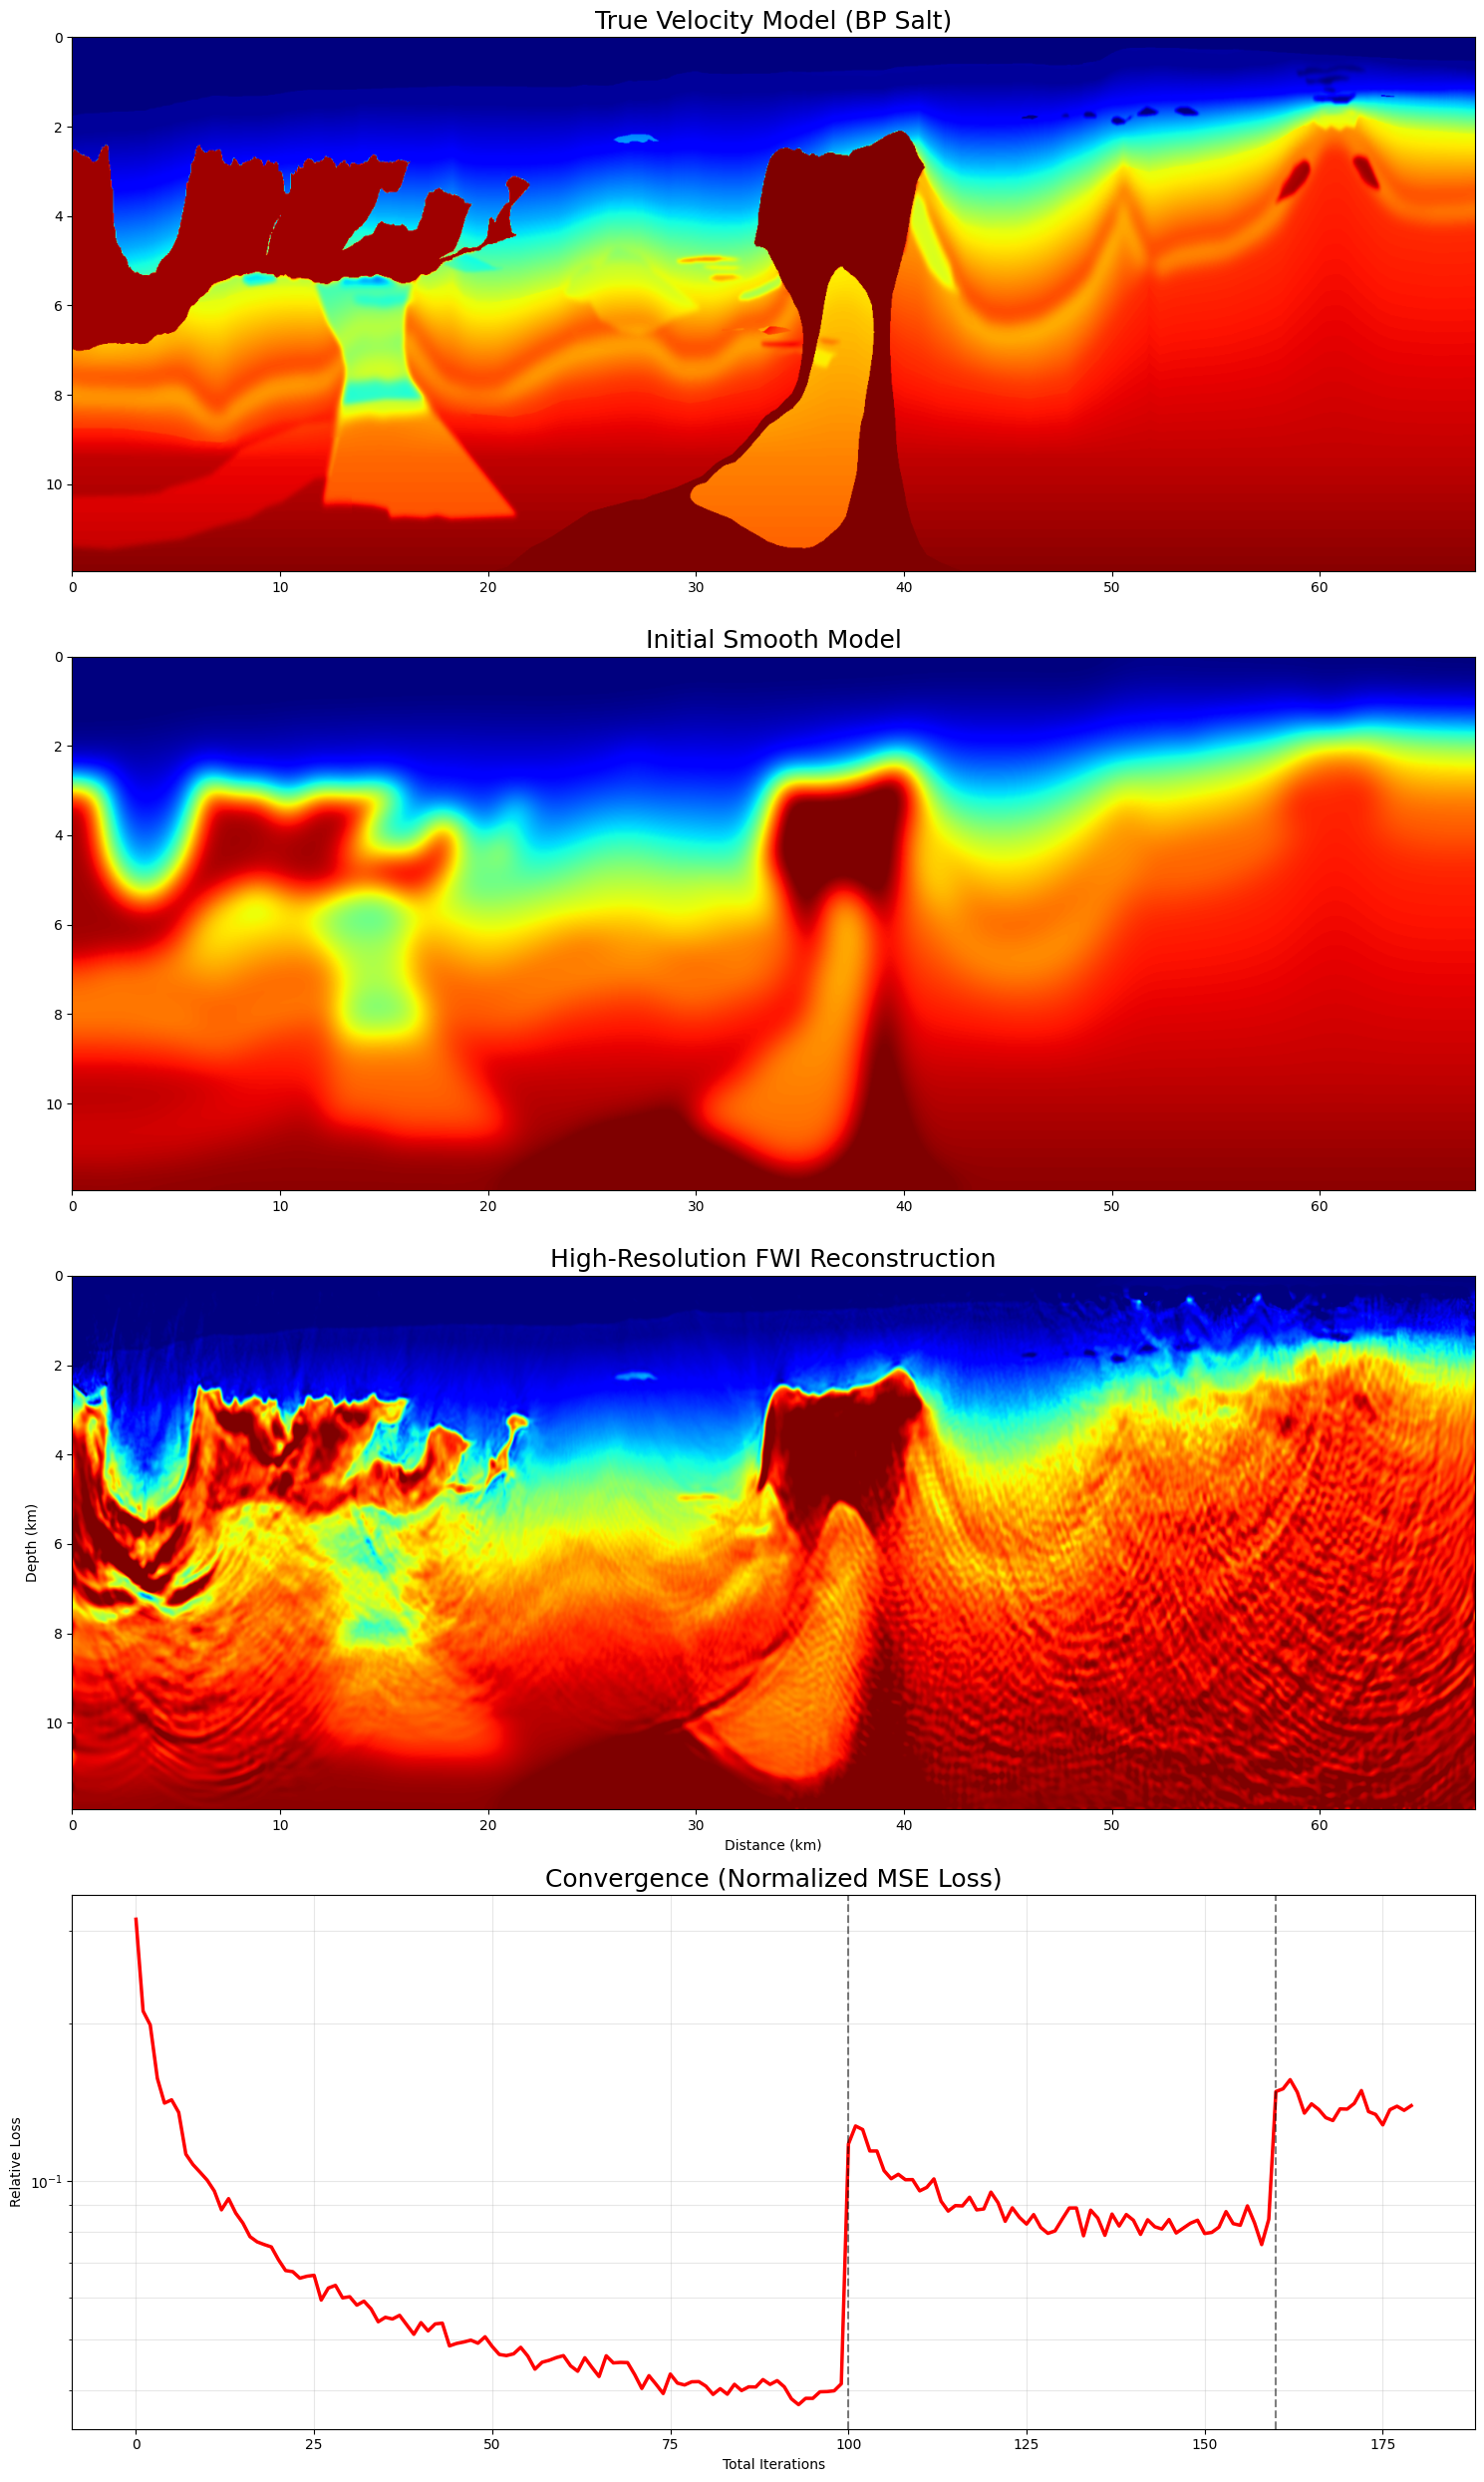

In [ ]:
import os
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION & MEMORY ---
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

#device = torch.device('cuda' if torch.available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- ADVANCED GPU SMOOTHING (Edge Preserving) ---
def gpu_smooth(img, sigma):
    if sigma <= 0.1: return img
    kernel_size = int(2 * 4 * sigma + 1)
    if kernel_size % 2 == 0: kernel_size += 1
    x = torch.arange(kernel_size).to(device) - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-x.pow(2) / (2 * sigma**2))
    kernel_1d /= kernel_1d.sum()
    kernel_2d = kernel_1d[:, None] * kernel_1d[None, :]
    kernel_2d = kernel_2d.expand(1, 1, -1, -1)
    img = F.pad(img.unsqueeze(0).unsqueeze(0), (kernel_size//2,)*4, mode='replicate')
    img = F.conv2d(img, kernel_2d)
    return img.squeeze()

# --- BP SALT MODEL LOADING ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.25

if not os.path.exists(vp_path):
    print("Warning: BP_salt.bin not found. Using dummy for script verification.")
    vp_cpu = torch.ones(nx0, nz0) * 2000.0
else:
    vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# Factor 3.0 (dx=37.5m) - This eliminates the 6Hz dispersion warning
factor = 3.0
vp_reduced = gaussian_filter(vp_cpu.numpy(), sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape
dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)

v_true = torch.from_numpy(vp_reduced).to(device)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=20)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION ---
n_shots = 24
batch_size = 3 # Adjusted for 15GB VRAM at dx=37.5
n_receivers_per_shot = 400
nt = 2000
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(20, nx - 21, n_shots).long()
source_loc[:, 0, 1] = 4

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 4
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0
z_grad = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 45.0 * z_grad**2.5).repeat(nx, 1) # Stronger weight for salt base

# --- MULTI-SCALE INVERSION ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = [100, 60, 20] # Updated iterations per frequency
# Gradual learning rate reduction
lrs = [25.0, 15.0, 8.0]
history = []

print(f"Grid: {nx}x{nz} | dx={dx:.1f}m | Target: {freqs[-1]}Hz")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Observe data with wider PML to avoid boundary reflections (ripples)
    with torch.no_grad():
        obs_data_list = []
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:min(i+batch_size, n_shots)],
                         source_locations=source_loc[i:min(i+batch_size, n_shots)],
                         receiver_locations=receiver_loc[i:min(i+batch_size, n_shots)],
                         pml_freq=freq, pml_width=[40, 40, 40, 40])
            obs_data_list.append(out[-1])
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage[f_idx]):
        optimizer.zero_grad()
        epoch_loss = 0

        # Randomize shots to help skip local minima
        perm = torch.randperm(n_shots)

        for i in range(0, n_shots, batch_size):
            indices = perm[i:min(i+batch_size, n_shots)]

            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[indices],
                              source_locations=source_loc[indices],
                              receiver_locations=receiver_loc[indices],
                              pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10) # VRAM Save

            # Normalizing loss by the scale of the observed data to prevent "jumps"
            loss = F.mse_loss(out_pred[-1], obs_data[indices]) / F.mse_loss(obs_data[indices], torch.zeros_like(obs_data[indices]))
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            # Apply Mask and Depth Gain
            v1.grad *= (mask * depth_weight)

            # Multi-scale smoothing: Sigma decreases as frequency increases
            sigma_val = 3.5 / (f_idx + 1)
            v1.grad.copy_(gpu_smooth(v1.grad, sigma=sigma_val))

        optimizer.step()

        # Hard constraints for BP model stability
        v1.data.clamp_(min=1450.0, max=4850.0)

        # Smooth the model itself slightly every epoch to prevent "checkerboard" artifacts
        if epoch % 2 == 0:
            v1.data.copy_(gpu_smooth(v1.data, sigma=0.2))

        avg_loss = epoch_loss / (n_shots // batch_size)
        history.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage[f_idx]} | Scaled Loss: {avg_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(4, 1, figsize=(15, 25))
extent = [0, (nx*dx)/1000, (nz*dz)/1000, 0]
opts = {'cmap': 'jet', 'aspect': 'auto', 'extent': extent, 'vmin': 1500, 'vmax': 4600}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model (BP Salt)", fontsize=18)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Initial Smooth Model", fontsize=18)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("High-Resolution FWI Reconstruction", fontsize=18)
ax[2].set_xlabel("Distance (km)")
ax[2].set_ylabel("Depth (km)")

# Improved Loss Plot
ax[3].plot(history, color='red', lw=2.5)
ax[3].set_title("Convergence (Normalized MSE Loss)", fontsize=18)
ax[3].set_xlabel("Total Iterations")
ax[3].set_ylabel("Relative Loss")
ax[3].set_yscale('log')
ax[3].grid(True, which="both", ls="-", alpha=0.3)
# Mark stage transitions
for i in range(1, len(freqs)):
    ax[3].axvline(x=sum(epochs_per_stage[:i]), color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Device: cuda
Model shape (nx, nz) = (900, 319), dx=75.0m, dz=37.6m


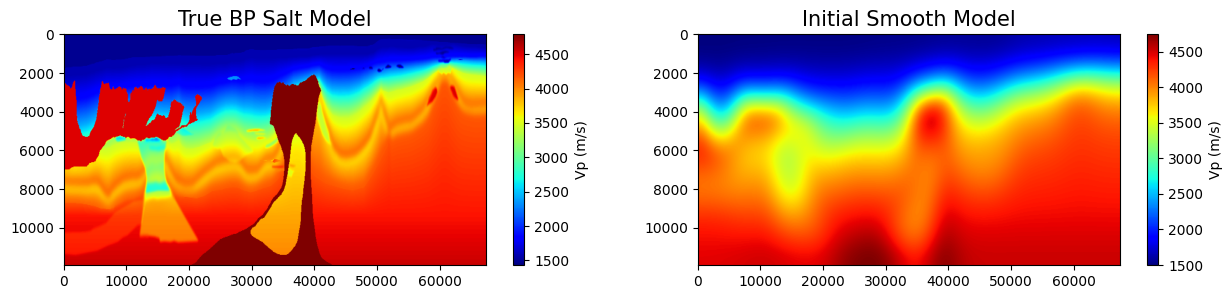


Starting Multiscale FWI...

--- STAGE 1: Frequency = 2.0 Hz ---
  Epoch 50: loss=152.52587


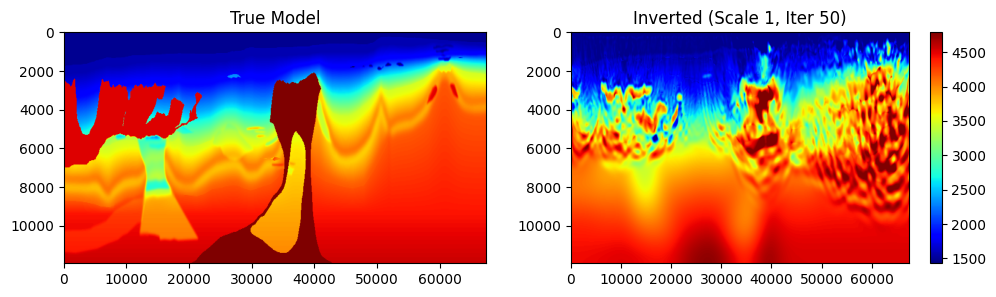

  Epoch 100: loss=18.56496


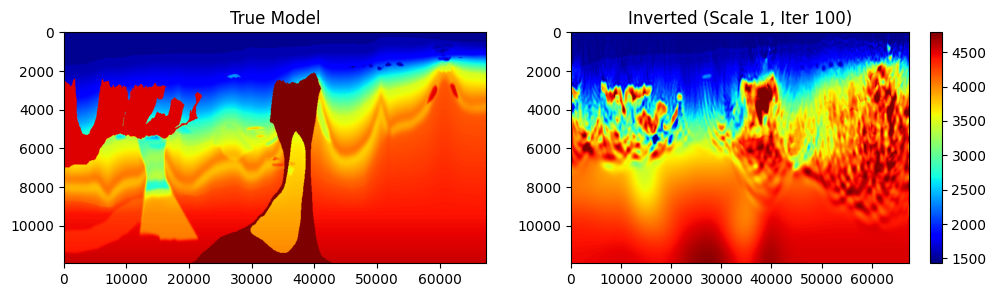


--- STAGE 2: Frequency = 4.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 75.0, there are only 4.76.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 4.0, a minimum non-zero velocity of 1480.0, and a grid cell spacing of 75.0, there are only 4.93.
  warnings.warn(


  Epoch 50: loss=5.20749


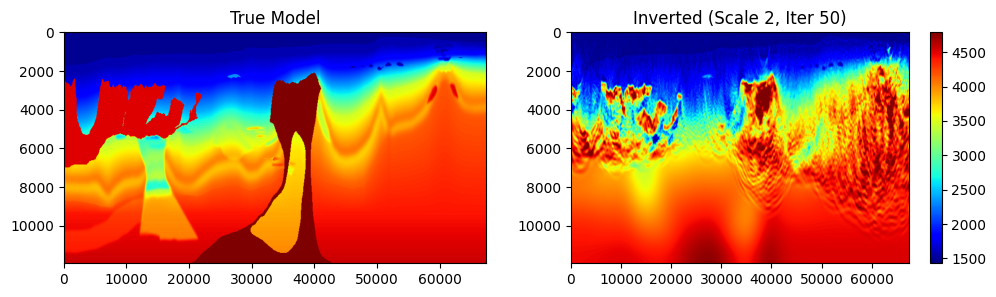

  Epoch 100: loss=1.98223


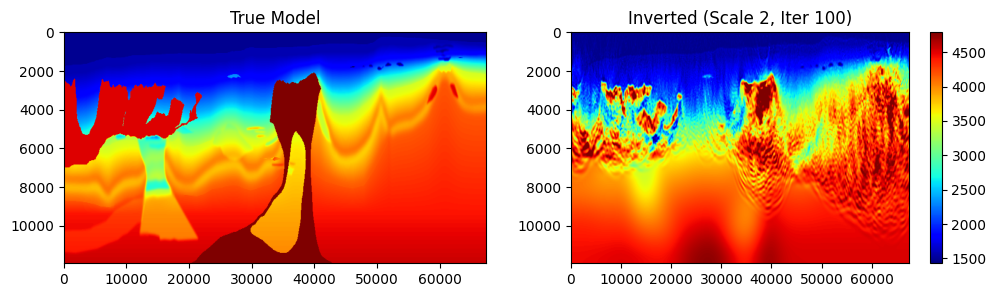


--- STAGE 3: Frequency = 7.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 75.0, there are only 2.72.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 7.0, a minimum non-zero velocity of 1480.0, and a grid cell spacing of 75.0, there are only 2.82.
  warnings.warn(


  Epoch 50: loss=2.18810


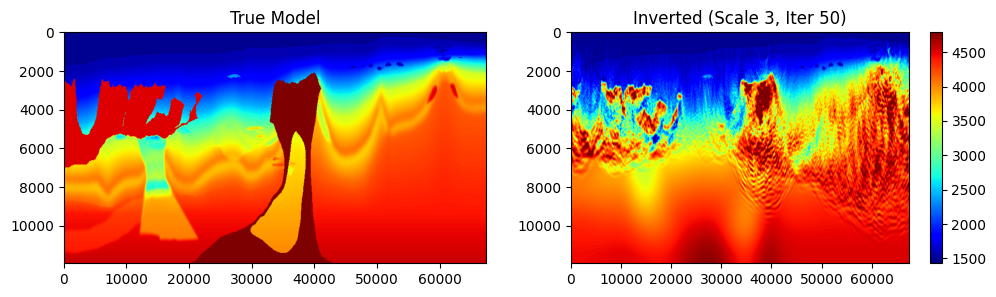

  Epoch 100: loss=1.06972


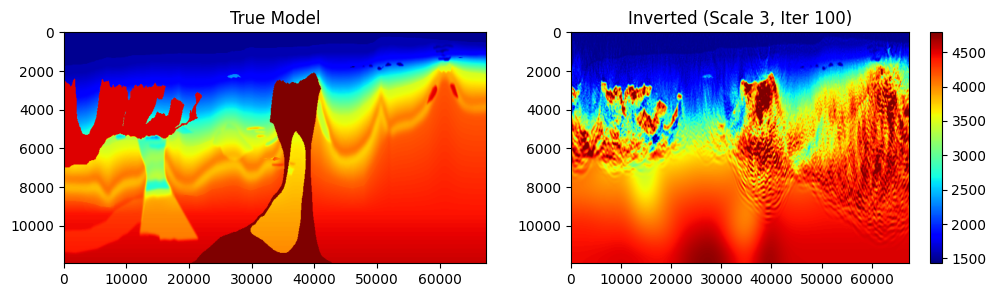

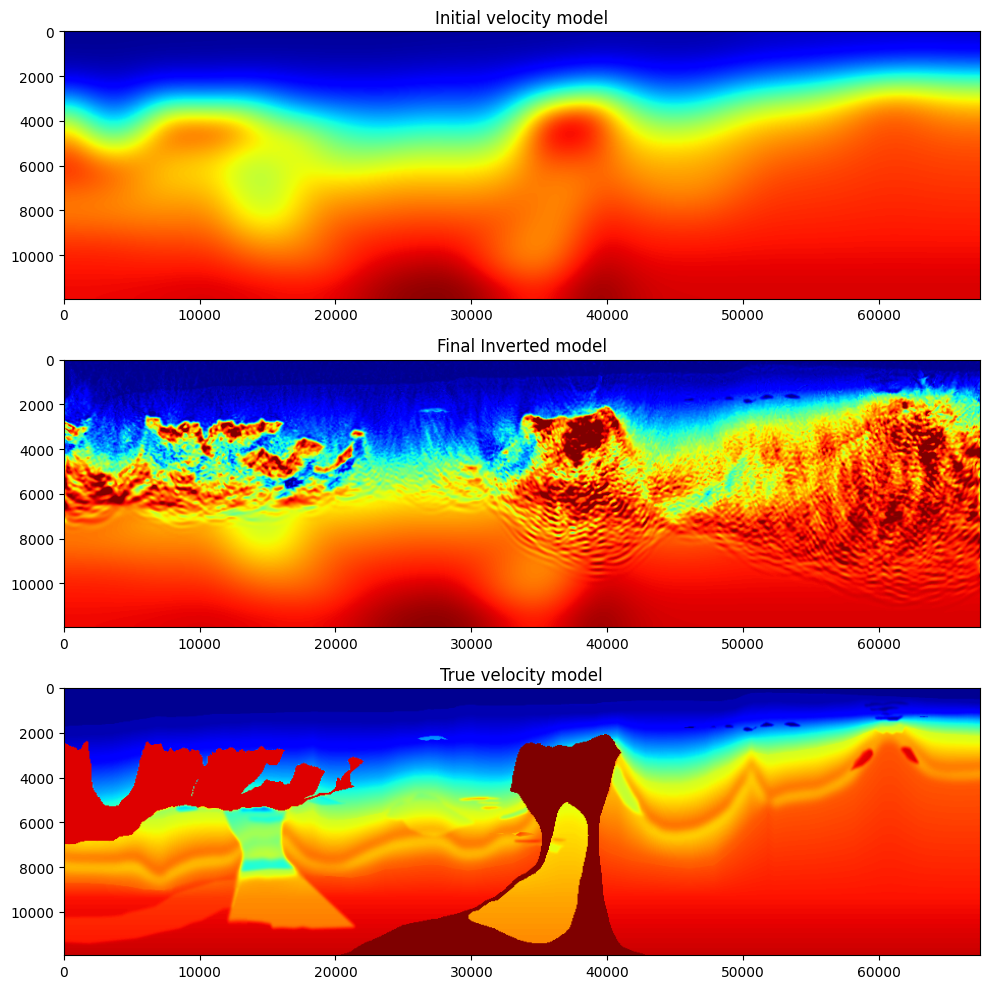

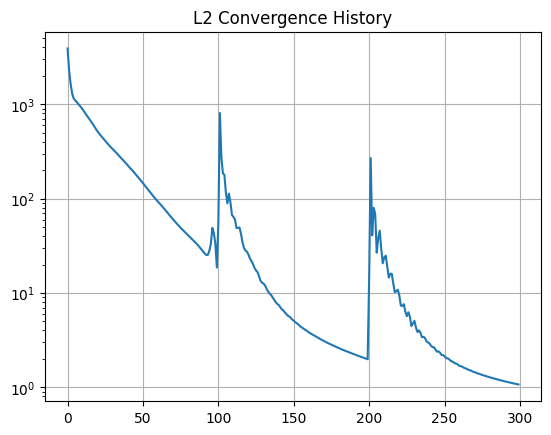

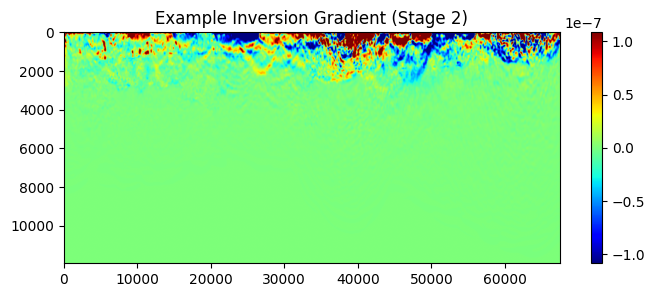

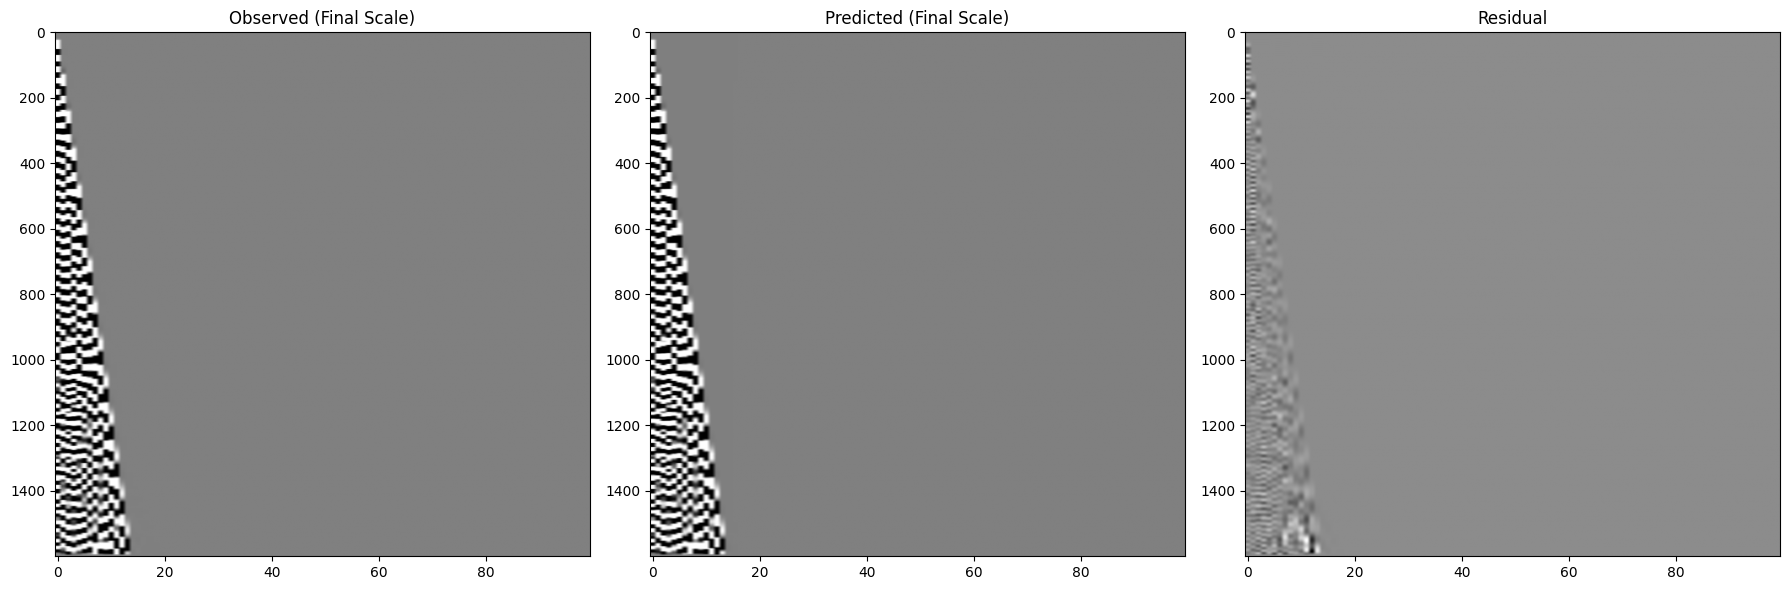

In [ ]:
# LIBRARIES AND SETTINGS
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 1. INPUT: BP SALT Vp BINARY FILE
# Dimensions based on your SU script: n1=1911 (z), n2=5395 (x)
vp_path = 'bp_salt_vp.bin'
nz0, nx0 = 1911, 5395

# Load and reshape to (nx, nz)
vp = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0).to(device)

# 2. PREPROCESSING: SUBSAMPLE (Factor 6 is optimized for T4 memory)
factor = 6
vp_np = vp.detach().cpu().numpy()
vp_reduced = vp_np[::factor, ::factor]
nx, nz = vp_reduced.shape

dx, dz = 12.5 * factor, 6.26 * factor
spacing = (dx, dz)
extent = [0, (nx-1)*dx, (nz-1)*dz, 0]

# TRUE AND INITIAL MODELS
v_true = torch.from_numpy(vp_reduced).to(device)
v_init = (torch.tensor(1/gaussian_filter(1/v_true.cpu().numpy(), 25)).to(device))
v1 = v_init.clone()
v1.requires_grad_()

print(f"Model shape (nx, nz) = {tuple(v_true.shape)}, dx={dx:.1f}m, dz={dz:.1f}m")

# PLOT TRUE AND INITIAL MODELS
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
im1 = ax1.imshow(v_true.cpu().T, cmap='jet', aspect='auto', extent=extent)
ax1.set_title('True BP Salt Model', fontsize=15)
im2 = ax2.imshow(v_init.cpu().T, cmap='jet', aspect='auto', extent=extent)
ax2.set_title('Initial Smooth Model', fontsize=15)
fig1.colorbar(im1, ax=ax1, label='Vp (m/s)')
fig1.colorbar(im2, ax=ax2, label='Vp (m/s)')
plt.show()

# 3. MULTISCALE PARAMETERS
# Starting low (2Hz) prevents "blobs", going high (7Hz) adds detail.
frequencies = [2.0, 4.0, 7.0]
iterations_per_scale = [100, 100, 100]
learning_rates = [7e1, 4e1, 2e1]

n_shots = 24
batch_size = 1  # Process 1 shot at a time to save T4 RAM
n_receivers_per_shot = 100
nt, dt = 1600, 0.004
loss_fn = torch.nn.MSELoss()

# Geometry Setup
source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

def taper(x): return deepwave.common.cosine_taper_end(x, 15)

# 4. MULTISCALE INVERSION LOOP
losses = []
gradients = []

print(f"\nStarting Multiscale FWI...")

for scale, freq in enumerate(frequencies):
    print(f"\n--- STAGE {scale+1}: Frequency = {freq} Hz ---")

    # Update wavelet for current scale
    peak_time = 1.5/freq
    source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
                  .repeat(n_shots, 1, 1).to(device))

    # Generate fresh observed data for current scale (prevents cycle skipping)
    with torch.no_grad():
        obs_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
        for i in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[i:i+batch_size],
                         source_locations=source_loc[i:i+batch_size],
                         receiver_locations=receiver_loc[i:i+batch_size], pml_freq=freq)
            obs_data[i:i+batch_size] = out[-1]

    obs_tapered = taper(obs_data)
    optimiser = torch.optim.Adam([v1], lr=learning_rates[scale])

    for epoch in range(iterations_per_scale[scale]):
        optimiser.zero_grad()
        epoch_loss = 0.0

        for i in range(0, n_shots, batch_size):
            out_pred = scalar(v1, spacing, dt,
                              source_amplitudes=source_amp[i:i+batch_size],
                              source_locations=source_loc[i:i+batch_size],
                              receiver_locations=receiver_loc[i:i+batch_size], pml_freq=freq)
            loss = loss_fn(taper(out_pred[-1]), obs_tapered[i:i+batch_size])
            (loss / n_shots).backward()
            epoch_loss += loss.item()

        # GRADIENT POST-PROCESSING (Marmousi Reference Logic)
        with torch.no_grad():
            # Adaptive smoothing: more smoothing at low frequencies
            sigma_val = 2.5 / (scale + 1)
            grad_smoothed = gaussian_filter(v1.grad.detach().cpu().numpy(), sigma=sigma_val)
            v1.grad.copy_(torch.tensor(grad_smoothed).to(device))

            # Clipping
            clip_val = torch.quantile(v1.grad.abs(), 0.98)
            torch.nn.utils.clip_grad_value_([v1], clip_val)

        optimiser.step()
        with torch.no_grad(): v1.clamp_(min=1480.0, max=5200.0)

        losses.append(epoch_loss)

        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}: loss={epoch_loss:.5f}")
            fig, ax = plt.subplots(1, 2, figsize=(12, 3))
            ax[0].imshow(v_true.cpu().T, cmap='jet', aspect='auto', extent=extent)
            ax[0].set_title("True Model")
            im = ax[1].imshow(v1.detach().cpu().T, cmap='jet', aspect='auto', extent=extent, vmin=v_true.min(), vmax=v_true.max())
            ax[1].set_title(f"Inverted (Scale {scale+1}, Iter {epoch+1})")
            plt.colorbar(im, ax=ax[1])
            plt.show()

    # Store final gradient of the scale for plotting
    gradients.append(v1.grad.clone().detach().cpu())

# 5. FINAL VISUALIZATIONS
# Generate final predicted data for comparison
with torch.no_grad():
    predicted_data = torch.zeros_like(obs_data)
    for i in range(0, n_shots, batch_size):
        out_f = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+batch_size],
                       source_locations=source_loc[i:i+batch_size],
                       receiver_locations=receiver_loc[i:i+batch_size], pml_freq=freq)
        predicted_data[i:i+batch_size] = out_f[-1]

# FINAL VELOCITY COMPARISON (3 Panels)
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(v_init.cpu().T, aspect='auto', cmap='jet', extent=extent, vmin=v_true.min(), vmax=v_true.max())
ax[0].set_title("Initial velocity model")
ax[1].imshow(v1.detach().cpu().T, aspect='auto', cmap='jet', extent=extent, vmin=v_true.min(), vmax=v_true.max())
ax[1].set_title("Final Inverted model")
ax[2].imshow(v_true.cpu().T, aspect='auto', cmap='jet', extent=extent, vmin=v_true.min(), vmax=v_true.max())
ax[2].set_title("True velocity model")
plt.tight_layout(); plt.show()

# LOSS PLOT
plt.figure(); plt.semilogy(losses); plt.title("L2 Convergence History"); plt.grid(); plt.show()

# GRADIENT PLOT (From middle scale)
plt.figure(figsize=(8, 3))
plt.imshow(gradients[1].T, cmap='jet', aspect='auto', extent=extent)
plt.title("Example Inversion Gradient (Stage 2)"); plt.colorbar(); plt.show()

# DATA RESIDUAL PLOT
shot = 0
obs = obs_tapered[shot].detach().cpu()
pred = taper(predicted_data)[shot].detach().cpu()
res = pred - obs
amp = torch.quantile(obs.abs(), 0.95).item()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(obs.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp); axes[0].set_title("Observed (Final Scale)")
axes[1].imshow(pred.T, aspect="auto", cmap="gray", vmin=-amp, vmax=amp); axes[1].set_title("Predicted (Final Scale)")
axes[2].imshow(res.T, aspect="auto", cmap="gray"); axes[2].set_title("Residual")
plt.tight_layout(); plt.show()

Device: cuda
Model shape (nx, nz) = (801, 185), dx=25.0m, dz=25.0m


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2293: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


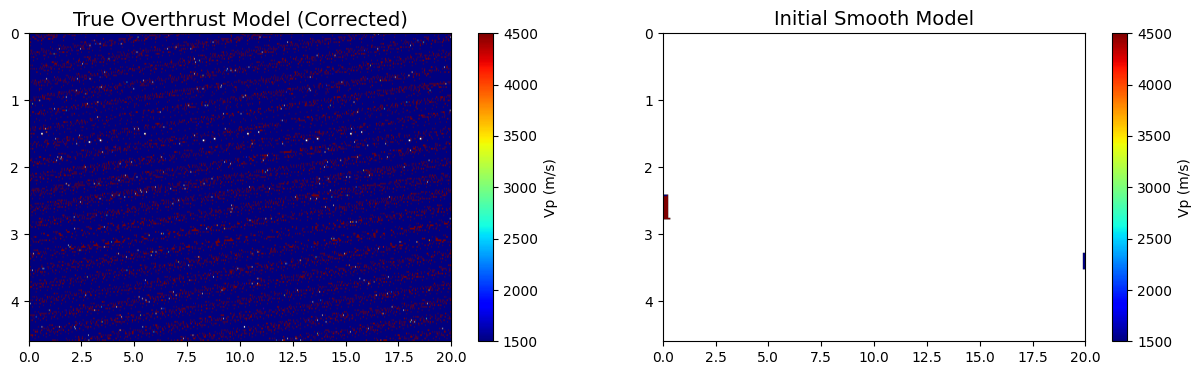


Starting Multiscale FWI...

--- STAGE 1: Frequency = 3.0 Hz ---


ValueError: cannot convert float NaN to integer

In [5]:
# LIBRARIES AND SETTINGS
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar
import gc

# Device: GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 1. FIXED INPUT: OVERTHRUST Vp BINARY FILE
# Dimensions: nz=185 (depth), nx=801 (distance)
vp_path = 'overthrust_vp.bin'
nz, nx = 185, 801

try:
    # 1. Read as Big-Endian ('>f4') which is standard for SEG binaries
    raw_data = np.fromfile(vp_path, dtype='>f4', count=nx*nz)

    # Check if we actually got Little-Endian data instead
    if raw_data.max() > 10000 or raw_data.max() < 500:
        raw_data = np.fromfile(vp_path, dtype='<f4', count=nx*nz)

    # 2. FIX BYTE ORDER ERROR: Convert to native byte order (float32)
    # This creates a copy that PyTorch can understand
    vp_np_native = raw_data.astype(np.float32)

    # 3. FIX STRIPES: Reshape to (nz, nx) and transpose to (nx, nz)
    vp_np = vp_np_native.reshape(nz, nx).T

except Exception as e:
    print(f"Error loading: {e}")
    # Fallback: simple load and native conversion
    raw = np.fromfile(vp_path, dtype='f4').astype(np.float32)
    vp_np = raw.reshape(-1, nz).T[:, :nx]

# Move to PyTorch
v_true = torch.from_numpy(vp_np).to(device)

# 2. PREPROCESSING
dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx-1)*dx/1000, (nz-1)*dz/1000, 0] # km for plotting

# INITIAL MODEL: Smooth the true model to create a starting guess
v_init_np = gaussian_filter(v_true.cpu().numpy(), sigma=[15, 5])
v_init = torch.tensor(v_init_np).to(device)
v1 = v_init.clone()
v1.requires_grad_()

print(f"Model shape (nx, nz) = {tuple(v_true.shape)}, dx={dx}m, dz={dz}m")

# PLOT TRUE AND INITIAL MODELS
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
im1 = ax1.imshow(v_true.cpu().T, cmap='jet', aspect='auto', extent=extent, vmin=1500, vmax=4500)
ax1.set_title('True Overthrust Model (Corrected)', fontsize=14)
im2 = ax2.imshow(v_init.cpu().T, cmap='jet', aspect='auto', extent=extent, vmin=1500, vmax=4500)
ax2.set_title('Initial Smooth Model', fontsize=14)
plt.colorbar(im1, ax=ax1, label='Vp (m/s)')
plt.colorbar(im2, ax=ax2, label='Vp (m/s)')
plt.show()

# 3. MEMORY OPTIMIZED PARAMETERS
frequencies = [3.0, 7.0] # Multi-scale stages
iterations_per_scale = [30, 30]
learning_rates = [4e1, 2e1]

# CONFIG FOR T4 GPU (16GB RAM)
n_shots = 16          # Reduced shot count for faster execution
batch_size = 1        # CRITICAL: 1 shot at a time to prevent OOM
n_receivers_per_shot = 150
nt, dt = 1000, 0.004  # Reduced time steps to save memory
loss_fn = torch.nn.MSELoss()

# Geometry (Sources/Receivers at surface)
source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(10, nx - 11, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(10, nx - 11, n_receivers_per_shot).round()

def taper(x): return deepwave.common.cosine_taper_end(x, 20)

# 4. MULTISCALE INVERSION LOOP
losses = []
print(f"\nStarting Multiscale FWI...")

for scale, freq in enumerate(frequencies):
    print(f"\n--- STAGE {scale+1}: Frequency = {freq} Hz ---")
    peak_time = 1.5/freq
    source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device))

    # Generate Synthetic "Observed" Data
    with torch.no_grad():
        obs_data = torch.zeros(n_shots, n_receivers_per_shot, nt, device=device)
        for i in range(n_shots):
            out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                         source_locations=source_loc[i:i+1],
                         receiver_locations=receiver_loc[i:i+1], pml_freq=freq)
            obs_data[i] = out[-1]
            torch.cuda.empty_cache() # Clear cache to keep memory low

    obs_tapered = taper(obs_data)
    optimiser = torch.optim.Adam([v1], lr=learning_rates[scale])

    for epoch in range(iterations_per_scale[scale]):
        optimiser.zero_grad()
        epoch_loss = 0.0

        # Shot-by-shot loop to stay under memory limits
        for i in range(n_shots):
            out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                              source_locations=source_loc[i:i+1],
                              receiver_locations=receiver_loc[i:i+1], pml_freq=freq)

            loss = loss_fn(taper(out_pred[-1]), obs_tapered[i:i+1])
            (loss / n_shots).backward()
            epoch_loss += loss.item()

            # Explicitly free memory
            del out_pred
            torch.cuda.empty_cache()

        # Gradient Conditioning
        with torch.no_grad():
            grad_sm = gaussian_filter(v1.grad.detach().cpu().numpy(), sigma=1.0)
            v1.grad.copy_(torch.tensor(grad_sm).to(device))
            torch.nn.utils.clip_grad_value_([v1], torch.quantile(v1.grad.abs(), 0.98))

        optimiser.step()
        with torch.no_grad(): v1.clamp_(min=1480.0, max=4800.0)
        losses.append(epoch_loss)

        if (epoch + 1) % 15 == 0:
            print(f"  Epoch {epoch+1}: loss={epoch_loss:.6f}")

# 5. FINAL RESULTS
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(v_init.cpu().T, aspect='auto', cmap='jet', extent=extent, vmin=1500, vmax=4500)
ax[0].set_title("Initial velocity model")
ax[1].imshow(v1.detach().cpu().T, aspect='auto', cmap='jet', extent=extent, vmin=1500, vmax=4500)
ax[1].set_title("Final Inverted model")
ax[2].imshow(v_true.cpu().T, aspect='auto', cmap='jet', extent=extent, vmin=1500, vmax=4500)
ax[2].set_title("True velocity model")
plt.tight_layout(); plt.show()

plt.figure(); plt.semilogy(losses); plt.title("L2 Convergence History"); plt.grid(); plt.show()